# Generate Hubert Codes and their CTC word segmentations for English Speech

(use conda env huggingface for this notebook)

# imports

In [64]:
import torch
from transformers import HubertForCTC, Wav2Vec2Processor
from datasets import load_dataset
import soundfile as sf
import librosa
from tqdm import tqdm
import os
import unicodedata
import re
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]

# check cuda

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Set paths for writing outputs

In [104]:
outdir = "/home/s1785140/data/LJSpeech-1.1/hubert_CTC_word_segmentation"
# outdir_with_repeats = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_transcription_with_grapheme_repeats"
# outdir_raw_outputs = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_raw_outputs"

os.makedirs(outdir, exist_ok=True)
# os.makedirs(outdir_with_repeats, exist_ok=True)
# os.makedirs(outdir_raw_outputs, exist_ok=True)

# load pretrained model and text processor

In [3]:
processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(device)

### examine the labels for each output id of the processor.tokenizer

In [83]:
tokenizer_output_vocab = processor.tokenizer.get_vocab()
print("tokenizer_output_vocab")
tokenizer_output_vocab

tokenizer_output_vocab


{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 'E': 5,
 'T': 6,
 'A': 7,
 'O': 8,
 'N': 9,
 'I': 10,
 'H': 11,
 'S': 12,
 'R': 13,
 'D': 14,
 'L': 15,
 'U': 16,
 'M': 17,
 'W': 18,
 'C': 19,
 'F': 20,
 'G': 21,
 'Y': 22,
 'P': 23,
 'B': 24,
 'V': 25,
 'K': 26,
 "'": 27,
 'X': 28,
 'J': 29,
 'Q': 30,
 'Z': 31}

# Get wavs

In [5]:
wav_dir = "/home/s1785140/data/LJSpeech-1.1/audio_data/LJSpeech-1.1/wavs" # LJSpeech wavs no additional processing
wavs = os.listdir(wav_dir)
wav_paths = [os.path.join(wav_dir, wav) for wav in wavs]
print(len(wav_paths))

13100


# Get text transcripts for WAVS and further normalise out non-apostrophe punctuation and make upper case

In [98]:
# load all text data and normalise to upper case, and only keep apostrophes
def text_normalize(text):
    """taken from https://github.com/Kyubyong/tacotron/blob/master/data_load.py"""
    vocab = " ABCDEFGHIJKLMNOPQRSTUVWXYZ'"
    text = ''.join(char for char in unicodedata.normalize('NFD', text)
                           if unicodedata.category(char) != 'Mn') # Strip accents
    text = re.sub("[^{}]".format(vocab), " ", text)
    text = re.sub("[ ]+", " ", text)
    text = text.rstrip()
    return text

with open("/home/s1785140/data/LJSpeech-1.1/audio_data/LJSpeech-1.1/metadata.csv") as f:
    lines = f.readlines()
    
norm_text = {}
transcript_output_vocab = set()

for line in lines:
    # grab normed text
    utt_id = line.split('|')[0]
    text = line.split('|')[-1]
    # further normalise
    text = text.rstrip('\n').upper()
    text = text_normalize(text)
    
    # add all chars to vocab
    transcript_output_vocab.update(text)
    
    norm_text[utt_id] = text

# determine vocab in corpus
print("transcript_output_vocab")
transcript_output_vocab

transcript_output_vocab


{' ',
 "'",
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z'}

# Get CTC HuBERT text targets from normalised text

In [ ]:
# process norm text into targets for CTC HuBERT 
ctc_targets_text = {}
for utt_id, text in list(norm_text.items()):
    #convert text to IDs
    with processor.as_target_processor():
        processed = processor(text).input_ids
    #convert ids back to tokens
    tokens = processor.tokenizer.convert_ids_to_tokens(processed, skip_special_tokens=False)
    assert '<unk>' not in tokens
    assert '<s>' not in tokens
    assert '</s>' not in tokens
    assert '<pad>' not in tokens
    ctc_targets_text[utt_id] = "".join(tokens)

In [ ]:
for utt_id, ctc_text in list(ctc_targets_text.items())[:5]:
    print(utt_id, "\n", norm_text[utt_id], "\n", ctc_text, "\n")

# Load LJspeech quantised using hubert (provided by Facebook)
Do this to check that number of timesteps agrees with what huggingface Hubert model outputs
So that we do not need to regenerate the hubert codes from scratch

In [125]:
# load ljspeech hubert codes from disk into dictionary
with open("/home/s1785140/fairseq/examples/speech_audio_corrector/lj_speech_quantized.txt") as f:
    lines = f.readlines()

fb_hubert_codes = {}
for l in lines:
    utt_id, codes = l.split('|')
    codes = codes.split(' ')
    codes = [int(c) for c in codes]
    fb_hubert_codes[utt_id] = codes

# Generate frame-wise label probability

In [126]:
wav_path = wav_paths[1]
utt_id = wav_path.split('/')[-1].split('.')[0]

### pass audio through model

In [127]:
ljspeech_sampling_rate = 22050
hubert_sampling_rate = 16000

# load speech and resample to same rate as hubert encoder requires
speech, _ = sf.read(wav_path)
speech = librosa.resample(speech, ljspeech_sampling_rate, hubert_sampling_rate)

# get audio inputs for hubert
input_values = processor(speech, return_tensors="pt", sampling_rate=hubert_sampling_rate).input_values.to(device)

# use hubert to encode audio inputs to logits over output vocabulary (characters)
emission = model(input_values).logits

# check shapes
print("input_values.size()", input_values.size()) # (b_sz, n_waveform_samples)
print("emission.size()", emission.size()) # (b_sz, n_frames, n_output_labels)

input_values.size() torch.Size([1, 42096])
emission.size() torch.Size([1, 131, 32])


### check if len of model CTC ASR outputs matches with hubert discrete codes provided by fb

In [128]:
assert len(fb_hubert_codes[utt_id]) == emission.size(1)

### compare ASR output with ground truth transcription (sanity check)

In [116]:
# inspect ASR decoded transcription vs ground truth transcription
predicted_ids = torch.argmax(emission, dim=-1)
asr_transcript = processor.decode(predicted_ids[0])
print("utt_id", utt_id)
print("asr_transcript", asr_transcript)
print("real_transcript", norm_text[utt_id])

utt_id LJ041-0060
asr_transcript CARIE THORNLY A MARINE ASSOCIATE
real_transcript KERRY THORNLEY A MARINE ASSOCIATE


In [117]:
s = "71 89 59 59 33 0 0 0 0 30 30 30 25 25 11 11 64 65 65 3 3 3 3 3 3 3 87 48 48 48 48 48 46 46 30 44 44 80 80 18 90 90 35 35 35 11 11 11 11 11 11 64 64 64 64 64 37 57 37 57 86 73 73 16 50 50 50 52 52 30 70 70 70 52 25 25 11 45 45 45 64 64 64 80 80 18 37 57 86 86 73 6 6 15 15 36 36 7 7 87 97 97 97 65 65 6 36 36 36 7 7 11 11 11 64 53 53 53 42 42 74 2 31 31 41 41 84 57 96 20 20"
items = s.split(" ")
len(items)

131

### visualise output emission/logits

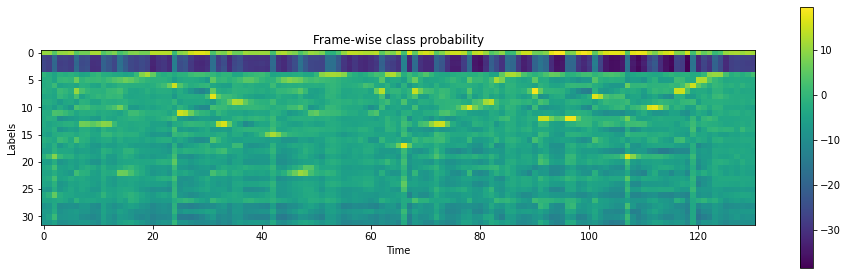

In [112]:
plt.imshow(emission.cpu().detach().T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

# Generate alignment probability (trellis)

In [ ]:
# visualise

# Find the most likely path (backtracking)

In [ ]:
# visualise

# old code from /Users/jonojace/github/fairseq/examples/speech_audio_corrector/Hubert_ASR_generate_transcripts.py

In [ ]:
# import torch
# from transformers import HubertForCTC, Wav2Vec2Processor
# from datasets import load_dataset
# import soundfile as sf
# import librosa

# processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
# model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft")

# def replace_pad(l, new_symbol='-'):
#     """<pad> refers to epsilon in CTC replace with another symbol for readability"""
#     new_l = []
#     for x in l:
#         if x == "<pad>":
#             new_l.append(new_symbol)
#         else:
#             new_l.append(x)
#     return new_l


# from itertools import groupby


# def reduce_tokens(
#         tokens,
#         pad_symbol="<pad>",
#         word_boundary_symbol="|",
#         remove_epsilons=True,
#         no_repeat_epsilons=False,
#         no_repeat_word_boundaries=False,
#         no_repeat_graphemes=False,
# ):
#     """
#     reduce a sequence of CTC output tokens that contains

#     args:
#         tokens: list of CTC model tokens to reduce
#         remove_epsilons: whether or not to leave epsilons in
#         no_repeat_epsilons: whether to reduce repeated epsilons to just one
#         no_repeat_graphemes: whether to reduce repeated graphemes to just one
#     """
#     reduced_tokens = []
#     all_symbols = []
#     all_durations = []

#     for symbol, group in groupby(tokens):
#         duration = sum(1 for _ in group)
#         all_symbols.append(symbol)
#         all_durations.append(duration)

#         if symbol == pad_symbol:
#             if remove_epsilons:
#                 pass
#             elif no_repeat_epsilons:
#                 reduced_tokens.append(symbol)
#             else:
#                 reduced_tokens.extend(duration * [symbol])
#         elif symbol == word_boundary_symbol:
#             if no_repeat_word_boundaries:
#                 reduced_tokens.append(symbol)
#             else:
#                 reduced_tokens.extend(duration * [symbol])
#         else:
#             if no_repeat_graphemes:
#                 reduced_tokens.append(symbol)
#             else:
#                 reduced_tokens.extend(duration * [symbol])

#     return reduced_tokens, all_symbols, all_durations


# import os
# wav_dir = "/home/s1785140/data/LJSpeech-1.1/wavs"
# wavs = os.listdir(wav_dir)
# wav_paths = [os.path.join(wav_dir, wav) for wav in wavs]

# from tqdm import tqdm

# outdir = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_transcription"
# outdir_with_repeats = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_transcription_with_grapheme_repeats"
# outdir_raw_outputs = "/home/s1785140/data/LJSpeech-1.1/hubert_asr_raw_outputs"

# os.makedirs(outdir, exist_ok=True)
# os.makedirs(outdir_with_repeats, exist_ok=True)
# os.makedirs(outdir_raw_outputs, exist_ok=True)

# print(len(wav_paths))

# all_transcriptions = []
# all_alt_transcriptions = []
# all_raw_outputs = []

# ljspeech_sampling_rate = 22050
# hubert_sampling_rate = 16000

# for i, wav_path in enumerate(tqdm(wav_paths[:])):
#     speech, _ = sf.read(wav_path)
#     speech = librosa.resample(speech, ljspeech_sampling_rate, hubert_sampling_rate)
#     utt_id = wav_path.split('/')[-1].split('.')[0]
#     input_values = processor(speech, return_tensors="pt").input_values
#     logits = model(input_values).logits
#     predicted_ids = torch.argmax(logits, dim=-1)
#     transcription = processor.decode(predicted_ids[0])

#     filtered_tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids[0].tolist(), skip_special_tokens=False)
#     reduced_tokens, all_symbols, all_durations = reduce_tokens(
#         filtered_tokens,
#         remove_epsilons=True,
#         no_repeat_epsilons=False,
#         no_repeat_word_boundaries=True,
#         no_repeat_graphemes=False
#     )
#     alt_transcription = replace_pad(reduced_tokens)
#     alt_transcription = [sym if sym != "|" else " " for sym in alt_transcription]
#     alt_transcription = "".join(alt_transcription)

#     raw_outputs = replace_pad(filtered_tokens)
#     raw_outputs = [sym if sym != "|" else " " for sym in raw_outputs]
#     raw_outputs = "".join(raw_outputs)

#     print(i, '===', raw_outputs)
#     print(i, '===', transcription)
#     print(i, '===', alt_transcription)

#     all_transcriptions.append(f"{utt_id}||{transcription.lower()}")
#     all_alt_transcriptions.append(f"{utt_id}||{alt_transcription.lower()}")
#     all_raw_outputs.append(f"{utt_id}||{raw_outputs.lower()}")

#     outfile = f"{utt_id}.txt"

#     # save proper transcription
#     with open(os.path.join(outdir, outfile), 'w') as f:
#         f.write(all_transcriptions[-1])

#     # save alternative transcription
#     with open(os.path.join(outdir_with_repeats, outfile), 'w') as f:
#         f.write(all_alt_transcriptions[-1])

#     # save raw outputs
#     with open(os.path.join(outdir_raw_outputs, outfile), 'w') as f:
#         f.write(all_raw_outputs[-1])

# outfile = f"metadata.csv"

# all_transcriptions = sorted(all_transcriptions)
# all_alt_transcriptions = sorted(all_alt_transcriptions)
# all_raw_outputs = sorted(all_raw_outputs)

# print(all_transcriptions)
# print(all_alt_transcriptions)
# print(all_raw_outputs)

# # save proper transcription
# with open(os.path.join(outdir, outfile), 'w') as f:
#     f.write("\n".join(all_transcriptions))

# # save alternative transcription
# with open(os.path.join(outdir_with_repeats, outfile), 'w') as f:
#     f.write("\n".join(all_alt_transcriptions))

# # save raw outputs
# with open(os.path.join(outdir_raw_outputs, outfile), 'w') as f:
#     f.write("\n".join(all_raw_outputs))
